# Coursework Template

**Dependencies and imports**

This can take a minute...

In [12]:
# !pip install swig
# !pip install --upgrade rldurham

In [13]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

**Reinforcement learning agent**

Replace this with your own agent, I recommend starting with TD3 (lecture 8).

In [14]:
class Agent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Agent, self).__init__()
        
        # Increase network capacity for more complex locomotion patterns
        self.policy = self._build_policy_network(state_dim, action_dim, hidden_dim)
        self.value = self._build_value_network(state_dim, hidden_dim)
        
        # Adjusted hyperparameters for bipedal walking
        self.gamma = 0.99
        self.learning_rate = 2e-4  # Slightly lower for more stable learning
        self.gae_lambda = 0.95
        self.clip_ratio = 0.2
        self.entropy_coef = 0.01
        self.value_coef = 0.5
        
        # Symmetric noise for balanced walking
        self.init_action_std = 0.4  # Reduced initial noise
        self.action_std = self.init_action_std
        self.action_std_decay = 0.997  # Slower decay
        self.min_action_std = 0.05
        self.noise_decay_start = 200  # More exploration time
        
        # Enhanced experience management
        self.trajectory = []
        self.value_normalizer = RunningMeanStd()
        self.state_normalizer = RunningMeanStd(shape=state_dim)
        self.reward_normalizer = RunningMeanStd()  # New: normalize rewards
        
        # Separate optimizers for policy and value networks
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=self.learning_rate)
        
        # Enhanced statistics tracking
        self.running_rewards = deque(maxlen=100)
        self.episode_count = 0
        self.best_reward = float('-inf')
        self.recent_actions = deque(maxlen=10)  # Increased window for smoother transitions
        
        # New: Track joint positions for symmetry enforcement
        self.joint_history = deque(maxlen=30)  # Track joint positions
        self.energy_costs = []  # Track energy consumption
        
    def _build_value_network(self, state_dim, hidden_dim):
        class ValueResidualBlock(nn.Module):
            def __init__(self, in_dim, out_dim):
                super().__init__()
                self.layers = nn.Sequential(
                    nn.Linear(in_dim, out_dim),
                    nn.LayerNorm(out_dim),
                    nn.GELU()  # GELU for better gradient properties
                )
                # Projection layer for residual connection if dimensions don't match
                self.projection = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()
                
            def forward(self, x):
                return self.layers(x) + self.projection(x)
        
        # Progressively wider layers help capture hierarchical features
        value = nn.Sequential(
            # Initial feature extraction
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            
            # First residual block - process low-level state features
            ValueResidualBlock(hidden_dim, hidden_dim),
            
            # Expand to capture more complex patterns
            ValueResidualBlock(hidden_dim, hidden_dim * 2),
            
            # Middle layers for temporal dependencies
            ValueResidualBlock(hidden_dim * 2, hidden_dim * 2),
            nn.Dropout(0.1),  # Light regularization
            
            # Contract back with skip connection
            ValueResidualBlock(hidden_dim * 2, hidden_dim),
            
            # Final value prediction
            nn.Linear(hidden_dim, 1)
        )
        
        # Specialized initialization for value estimation
        for layer in value.modules():
            if isinstance(layer, nn.Linear):
                # Smaller initialization for more precise value estimates
                torch.nn.init.orthogonal_(layer.weight, gain=np.sqrt(2)/2)
                torch.nn.init.zeros_(layer.bias)
                
                # Add weight decay to final layer for stability
                if layer == value[-1]:
                    layer.weight.data.mul_(0.1)
        
        return value
        
    def _build_policy_network(self, state_dim, action_dim, hidden_dim):
        """Enhanced policy network with residual connections"""
        class ResidualBlock(nn.Module):
            def __init__(self, dim):
                super().__init__()
                self.layers = nn.Sequential(
                    nn.Linear(dim, dim),
                    nn.LayerNorm(dim),
                    nn.Tanh()
                )
                
            def forward(self, x):
                return x + self.layers(x)
        
        policy = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Tanh(),
            ResidualBlock(hidden_dim),
            ResidualBlock(hidden_dim),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()
        )
        
        # Initialize with smaller weights for fine control
        for layer in policy.modules():
            if isinstance(layer, nn.Linear):
                torch.nn.init.orthogonal_(layer.weight, gain=0.8)
                torch.nn.init.zeros_(layer.bias)
        
        return policy
    
    def compute_energy_cost(self, actions, joint_velocities):
        """Compute energy cost of actions for more efficient walking"""
        # Approximate energy as sum of absolute work done by joints
        energy_cost = torch.sum(torch.abs(actions * joint_velocities))
        self.energy_costs.append(energy_cost.item())
        return energy_cost
    
    def enforce_symmetry(self, action):
        """Enforce symmetrical walking patterns"""
        # Assuming action structure: [left_hip, left_knee, right_hip, right_knee]
        left_side = action[:2]
        right_side = action[2:]
        
        # Blend with mirrored actions for more natural walking
        mirror_factor = 0.3
        blended_left = (1 - mirror_factor) * left_side + mirror_factor * right_side
        blended_right = (1 - mirror_factor) * right_side + mirror_factor * left_side
        
        return torch.cat([blended_left, blended_right])
    
    def sample_action(self, state):
        """Enhanced action sampling with symmetry and energy considerations"""
        state = self.normalize_state(state)
        
        with torch.no_grad():
            mean_action = self.policy(state)
            
            # Apply symmetry constraints
            mean_action = self.enforce_symmetry(mean_action)
            
            # Add controlled noise that preserves symmetry
            noise = torch.randn_like(mean_action) * self.action_std
            noise[:2] = 0.5 * (noise[:2] + noise[2:])  # Correlate left-right noise
            noise[2:] = noise[:2]
            
            action = torch.clamp(mean_action + noise, -1, 1)
            
            # Enhanced temporal smoothing with variable factor
            if len(self.recent_actions) > 0:
                prev_actions = torch.stack([torch.FloatTensor(a) for a in self.recent_actions])
                smooth_factor = 0.8 * (1 - torch.exp(-torch.norm(action - prev_actions[-1])))
                action = smooth_factor * action + (1 - smooth_factor) * prev_actions[-1]
            
            self.recent_actions.append(action.numpy())
            
            # Track joint positions for analysis
            self.joint_history.append(action.numpy())
        
        return action.numpy()
    
    def compute_stability_reward(self, state):
        """Compute additional reward term for stability"""
        # Extract relevant state components (assuming state contains COM and joint info)
        com_height = state[0]  # Center of mass height
        com_velocity = state[1:4]  # Center of mass velocity
        joint_angles = state[4:8]  # Joint angles
        
        # Reward stable height and penalize excessive COM movement
        height_reward = -abs(com_height - 0.8)  # Target height of 0.8
        velocity_penalty = -0.1 * torch.norm(torch.FloatTensor(com_velocity))
        posture_penalty = -0.05 * torch.norm(torch.FloatTensor(joint_angles))
        
        return height_reward + velocity_penalty + posture_penalty
    
    def train(self):
        """Update policy and value networks using collected experience.
        
        This method processes the stored trajectories and performs multiple epochs
        of policy optimization using PPO. It includes specific handling for bipedal
        walking data and ensures proper tensor conversion.
        
        Returns:
            tuple: (policy_loss, value_loss) for monitoring training progress
        """
        if len(self.trajectory) < 1:
            return 0, 0
        
        # Unpack trajectory data with proper tensor conversion
        states, actions, rewards, next_states, dones = [], [], [], [], []
        
        for transition in self.trajectory:
            # Each transition is (state, action, reward, next_state, done)
            states.append(transition[0])
            # Ensure actions are properly converted to tensors
            if isinstance(transition[1], np.ndarray):
                actions.append(torch.FloatTensor(transition[1]))
            elif isinstance(transition[1], torch.Tensor):
                actions.append(transition[1])
            else:
                actions.append(torch.FloatTensor([transition[1]]))
            rewards.append(transition[2])
            next_states.append(transition[3])
            dones.append(transition[4])
        
        # Convert lists to tensors
        try:
            states = torch.stack(states)
            actions = torch.stack(actions)
            rewards = torch.FloatTensor(rewards)
            next_states = torch.stack(next_states)
            dones = torch.FloatTensor(dones)
        except Exception as e:
            print("Error in tensor conversion:")
            print(f"States shape: {[s.shape for s in states]}")
            print(f"Actions shape: {[a.shape for a in actions]}")
            raise e
        
        # Normalize rewards for more stable training
        rewards = torch.FloatTensor(self.reward_normalizer(rewards.numpy()))
        
        # Compute advantages with stability considerations
        with torch.no_grad():
            values = self.value(states).squeeze()
            next_values = self.value(next_states).squeeze()
            
            # Compute GAE (Generalized Advantage Estimation)
            advantages = torch.zeros_like(rewards)
            gae = 0
            for t in reversed(range(len(rewards))):
                if t == len(rewards) - 1:
                    next_value = next_values[t]
                else:
                    next_value = values[t + 1]
                
                # Include energy efficiency in advantage computation if available
                energy_penalty = 0
                if hasattr(self, 'energy_costs') and self.energy_costs:
                    energy_penalty = -0.01 * self.energy_costs[t]
                
                delta = rewards[t] + energy_penalty + self.gamma * next_value * (1 - dones[t]) - values[t]
                gae = delta + self.gamma * self.gae_lambda * (1 - dones[t]) * gae
                advantages[t] = gae
            
            # Compute returns and normalize advantages
            returns = advantages + values
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Get initial action probabilities
        mean_actions = self.policy(states)
        dist = torch.distributions.Normal(mean_actions, self.action_std)
        old_log_probs = dist.log_prob(actions).sum(dim=1)
        
        # Multiple epochs of optimization for better sample efficiency
        for _ in range(4):
            # Compute new action probabilities
            mean_actions = self.policy(states)
            dist = torch.distributions.Normal(mean_actions, self.action_std)
            new_log_probs = dist.log_prob(actions).sum(dim=1)
            entropy = dist.entropy().mean()
            
            # Compute policy loss with clipping
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Compute value loss
            value_pred = self.value(states).squeeze()
            value_loss = F.mse_loss(value_pred, returns.detach())
            
            # Combined loss with entropy bonus
            loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy
            
            # Optimization step with gradient clipping
            self.value_optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)
            self.value_optimizer.step()
        
        # Clear buffers
        self.trajectory = []
        if hasattr(self, 'energy_costs'):
            self.energy_costs = []
        
        # Update exploration noise
        if self.episode_count > self.noise_decay_start:
            self.action_std = max(self.min_action_std, 
                                self.action_std * self.action_std_decay)
        
        return policy_loss.item(), value_loss.item()
    
    def _compute_policy_loss(self, new_log_probs, advantages, entropy):
        """Compute policy loss with adaptive KL penalty"""
        ratio = torch.exp(new_log_probs - old_log_probs.detach())
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
        
        # Add KL divergence term for more stable updates
        kl_div = torch.mean((ratio - 1) - torch.log(ratio))
        kl_penalty = 0.01 * kl_div
        
        return -torch.min(surr1, surr2).mean() + kl_penalty - self.entropy_coef * entropy
    def update_stats(self, episode_reward):
        """Update running statistics and episode count"""
        self.running_rewards.append(episode_reward)
        self.episode_count += 1
        self.best_reward = max(self.best_reward, episode_reward)
    
    def get_average_reward(self):
        """Calculate average reward over last 100 episodes"""
        return np.mean(self.running_rewards) if self.running_rewards else 0
    
    def reset(self):
        """Reset temporal smoothing between episodes"""
        self.recent_actions.clear()
        
    def normalize_state(self, state):
        """Normalize state values while maintaining original dimensionality.
        
        Args:
            state: Raw state vector from the environment
            
        Returns:
            Normalized state tensor with original dimensions preserved
        """
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state)
        
        # Convert to numpy for normalization
        state_np = state.numpy()
        
        # Update running statistics
        self.state_normalizer(state_np)
        
        # Normalize using running statistics
        normalized_state = (state_np - self.state_normalizer.mean) / \
                        (np.sqrt(self.state_normalizer.var) + 1e-8)
        
        # Clip normalized values to prevent extremes
        normalized_state = np.clip(normalized_state, -10, 10)
        
        return torch.FloatTensor(normalized_state)
    
    def put_data(self, state, action, reward, next_state, done):
        """Store a transition in the agent's experience buffer.
        
        This method handles the storage of experience transitions with proper
        normalization and preprocessing specifically designed for bipedal walking data.
        
        Args:
            state: Current state observation from the environment
            action: Action taken by the agent
            reward: Reward received from the environment
            next_state: Next state observation
            done: Boolean indicating if the episode has terminated
        """
        # Normalize states before storage
        state = self.normalize_state(state)
        next_state = self.normalize_state(next_state)
        
        # Convert action to tensor if it's not already
        if isinstance(action, np.ndarray):
            action = torch.FloatTensor(action)
        
        # Store transition in the trajectory buffer
        self.trajectory.append((
            state,                    # Normalized current state
            action,                   # Action taken
            float(reward),           # Reward received (converted to float)
            next_state,              # Normalized next state
            float(done)              # Episode termination flag
        ))
        
        # Update reward statistics for normalization
        if hasattr(self, 'reward_normalizer'):
            self.reward_normalizer(np.array([reward]))
        
        # If we're using energy tracking, compute and store energy cost
        if hasattr(self, 'energy_costs'):
            # Assuming action represents joint torques and next_state includes velocities
            joint_velocities = next_state[6:10]  # Adjust indices based on your state space
            energy_cost = torch.sum(torch.abs(action * torch.FloatTensor(joint_velocities)))
            self.energy_costs.append(energy_cost.item())
        
        # Optional: Add extra information for bipedal walking
        if hasattr(self, 'joint_history'):
            # Track joint positions for analyzing walking patterns
            joint_positions = state[2:6]  # Adjust indices based on your state space
            self.joint_history.append(joint_positions)

class RunningMeanStd:
    """Tracks running mean and standard deviation for normalization"""
    def __init__(self, shape=(), epsilon=1e-4):
        self.mean = np.zeros(shape, dtype=np.float32)
        self.var = np.ones(shape, dtype=np.float32)
        self.count = epsilon
        
    def __call__(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0] if len(x.shape) > 1 else 1
        
        delta = batch_mean - self.mean
        self.mean += delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        self.var = M2 / (self.count + batch_count)
        self.count += batch_count
        
        return (x - self.mean) / np.sqrt(self.var + 1e-8)

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


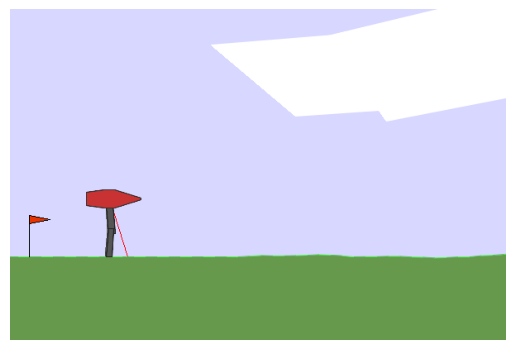

In [15]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

In [16]:
# # in the submission please use seed_everything with seed 42 for verification
# seed, observation, info = rld.seed_everything(42, env)

# # initialise agent
# agent = Agent(obs_dim, act_dim)
# max_episodes = 1000
# max_timesteps = 2000

# # track statistics for plotting
# tracker = rld.InfoTracker()

# # switch video recording off (only switch on every x episodes as this is slow)
# env.video = False

# for episode in range(max_episodes):
#     # Set up episode
#     env.info = episode % 10 == 0
#     env.video = episode % 10 == 0
#     current_observation, info = env.reset()
#     episode_reward = 0
    
#     # Reset agent's temporal smoothing
#     agent.reset()
    
#     # Run episode
#     for t in range(max_timesteps):
#         # Get action from agent
#         action = agent.sample_action(current_observation)
        
#         # Take step in environment
#         next_observation, reward, terminated, truncated, info = env.step(action)
        
#         # Store transition and update episode reward
#         agent.put_data(current_observation, action, float(reward), next_observation, 
#                       terminated or truncated)
#         episode_reward += reward
        
#         # Update observation
#         current_observation = next_observation
        
#         # Check if episode is done
#         if terminated or truncated:
#             break
    
#     # Train agent and update statistics
#     policy_loss, value_loss = agent.train()
#     agent.update_stats(episode_reward)
    
#     # Print progress every 10 episodes
#     if episode % 10 == 0:
#         avg_reward = agent.get_average_reward()
#         print(f"Episode {episode+1}, Reward: {episode_reward:.2f}, "
#               f"Avg Reward: {avg_reward:.2f}, "
#               f"Action STD: {agent.action_std:.3f}")
    
#     # Track and plot
#     tracker.track(info)
#     if (episode + 1) % 10 == 0:
#         tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

# env.close()

# # Write log file
# env.write_log(folder="logs", file="xxxx00-agent-log.txt")

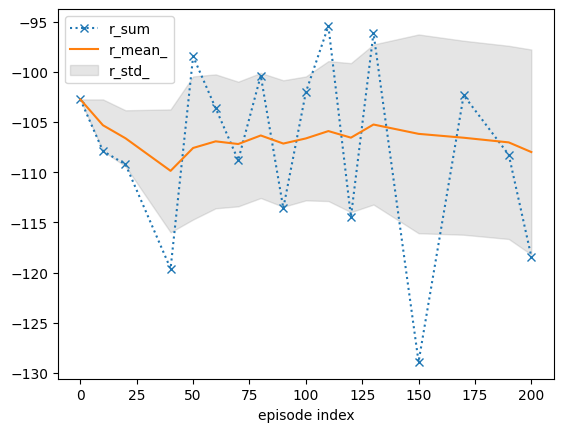

Episode 202 terminated early due to poor performance
Episode 204 terminated early due to poor performance
Episode 205 terminated early due to poor performance
Episode 206 terminated early due to poor performance
Stopping early at episode 208 due to no improvement


In [17]:
# Set up consistent random seeds for reproducibility
seed, observation, info = rld.seed_everything(42, env)
torch.manual_seed(42)
np.random.seed(42)

# Training configuration
max_episodes = 1000
max_timesteps = 2000
eval_frequency = 10  # How often to run evaluation episodes
min_training_reward = -100  # Early stopping for catastrophic episodes
early_stop_patience = 50  # Episodes to wait before early stopping
save_best_model = True  # Whether to save the best performing model

# Initialize agent and performance tracking
agent = Agent(obs_dim, act_dim)
tracker = rld.InfoTracker()
best_average_reward = float('-inf')
episodes_without_improvement = 0
running_rewards = []

# Training loop with evaluation and early stopping
for episode in range(max_episodes):
    # Configure environment settings
    is_eval_episode = episode % eval_frequency == 0
    env.info = is_eval_episode
    env.video = is_eval_episode
    
    # Episode setup
    current_observation, info = env.reset()
    episode_reward = 0
    episode_steps = 0
    agent.reset()  # Reset agent's temporal smoothing
    
    # Store episode transitions for analysis
    episode_states = []
    episode_actions = []
    episode_rewards = []
    
    # Run episode
    for t in range(max_timesteps):
        # Sample action and store state
        action = agent.sample_action(current_observation)
        episode_states.append(current_observation)
        episode_actions.append(action)
        
        # Take environment step
        next_observation, reward, terminated, truncated, info = env.step(action)
        episode_done = terminated or truncated
        
        # Store transition and update tracking
        agent.put_data(current_observation, action, float(reward), next_observation, episode_done)
        episode_reward += reward
        episode_rewards.append(reward)
        episode_steps += 1
        
        # Update observation
        current_observation = next_observation
        
        # Break if episode is done
        if episode_done:
            break
    
    # Analyze episode performance
    if episode_reward < min_training_reward:
        print(f"Episode {episode+1} terminated early due to poor performance")
        # Skip training for catastrophically bad episodes
        agent.trajectory = []
    else:
        # Train agent only if episode wasn't catastrophic
        policy_loss, value_loss = agent.train()
        
        # Update statistics and tracking
        agent.update_stats(episode_reward)
        running_rewards.append(episode_reward)
        
        # Calculate statistics over recent episodes
        recent_average = agent.get_average_reward()
        
        # Update best model if performance improved
        if save_best_model and recent_average > best_average_reward:
            best_average_reward = recent_average
            episodes_without_improvement = 0
            # Save model weights
            torch.save({
                'policy_state_dict': agent.policy.state_dict(),
                'value_state_dict': agent.value.state_dict(),
                'optimizer_state_dict': agent.value_optimizer.state_dict(),
                'episode': episode,
                'reward': recent_average
            }, 'best_walker_model.pth')
        else:
            episodes_without_improvement += 1
        
        # Early stopping check
        if episodes_without_improvement >= early_stop_patience:
            print(f"Stopping early at episode {episode+1} due to no improvement")
            break
        
        # Detailed logging for evaluation episodes
        if is_eval_episode:
            # Calculate episode statistics
            avg_reward = np.mean(running_rewards[-eval_frequency:])
            std_reward = np.std(running_rewards[-eval_frequency:])
            
            print(f"Episode {episode+1}")
            print(f"  Reward: {episode_reward:.2f}")
            print(f"  Average Reward (last {eval_frequency}): {avg_reward:.2f} ± {std_reward:.2f}")
            print(f"  Best Average Reward: {best_average_reward:.2f}")
            print(f"  Episode Steps: {episode_steps}")
            print(f"  Action STD: {agent.action_std:.3f}")
            print(f"  Policy Loss: {policy_loss:.3e}")
            print(f"  Value Loss: {value_loss:.3e}")
            
            # Additional analysis for evaluation episodes
            if len(episode_states) > 0:
                states_array = np.array(episode_states)
                actions_array = np.array(episode_actions)
                
                # Analyze state distributions
                state_means = np.mean(states_array, axis=0)
                state_stds = np.std(states_array, axis=0)
                
                # Analyze action distributions
                action_means = np.mean(actions_array, axis=0)
                action_stds = np.std(actions_array, axis=0)
                
                print("  State Statistics:")
                print(f"    Means: {state_means.round(3)}")
                print(f"    Stds: {state_stds.round(3)}")
                print("  Action Statistics:")
                print(f"    Means: {action_means.round(3)}")
                print(f"    Stds: {action_stds.round(3)}")
    
    # Track and plot
    tracker.track(info)
    if is_eval_episode:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

# Clean up and save final results
env.close()
env.write_log(folder="logs", file="walker-agent-log.txt")

# Save final model
torch.save({
    'policy_state_dict': agent.policy.state_dict(),
    'value_state_dict': agent.value.state_dict(),
    'optimizer_state_dict': agent.value_optimizer.state_dict(),
    'episode': max_episodes,
    'reward': agent.get_average_reward()
}, 'final_walker_model.pth')

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [18]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42
